<a href="https://colab.research.google.com/github/Blaze10/DL/blob/main/regularization/L2_regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from IPython import display
display.set_matplotlib_formats('svg')

In [3]:
iris = sns.load_dataset('iris')

In [5]:
data = torch.tensor(iris[iris.columns[:4]].values).float()
labels = torch.zeros(len(data), dtype=torch.long)

In [10]:
iris.species.value_counts()

setosa        50
versicolor    50
virginica     50
Name: species, dtype: int64

In [11]:
labels[iris.species == 'versicolor'] = 1
labels[iris.species == 'virginica'] = 2

## Break the data into batches

In [12]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=.2)
train_dataset = torch.utils.data.TensorDataset(train_data, train_labels)
test_dataset = torch.utils.data.TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=64, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

In [13]:
def create_model(l2Lambda):
  ANNiris = nn.Sequential(
      nn.Linear(4,64),
      nn.ReLU(),
      nn.Linear(64,64),
      nn.ReLU(),
      nn.Linear(64, 3)
  )

  loss_fun = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(ANNiris.parameters(), lr=0.005, weight_decay=l2Lambda)
  return ANNiris, loss_fun, optimizer

In [14]:
num_epochs = 1000
def train_model():
  train_acc = []
  test_acc = []
  losses = []

  for epochi in range(num_epochs):
    batch_acc = []
    batch_loss = []

    for X,y in train_loader:
      yHat = ANNiris(X)
      loss = loss_fun(yHat, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batch_acc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()).item())
      batch_loss.append(loss.item())

    train_acc.append(np.mean(batch_acc))
    losses.append(np.mean(batch_loss))

    ANNiris.eval()
    X,y = next(iter(test_loader))
    predlabels = torch.argmax(ANNiris(X), axis=1)
    test_acc.append(100 * torch.mean((predlabels == y).float()).item())

    ANNiris.train()

  return train_acc, test_acc, losses

In [15]:
l2Lambda = .01
ANNiris, loss_fun, optimizer = create_model(l2Lambda)

In [16]:
train_acc, test_acc, losses = train_model()

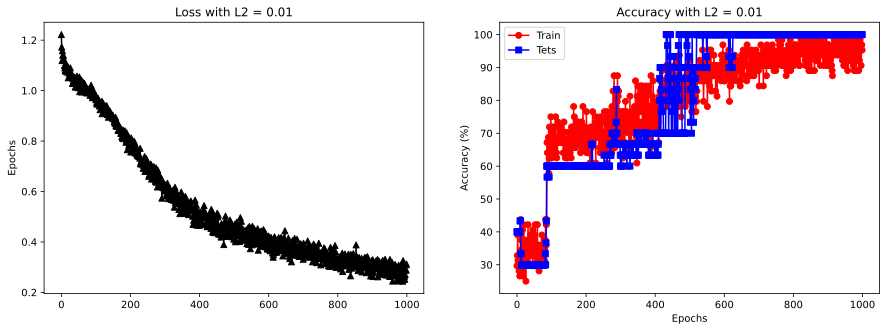

In [17]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(losses, 'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_ylabel('Epochs')
ax[0].set_title(f'Loss with L2 = {l2Lambda}')

ax[1].plot(train_acc, 'ro-')
ax[1].plot(test_acc, 'bs-')
ax[1].set_title(f'Accuracy with L2 = {l2Lambda}')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train', 'Tets'])

plt.show()

In [18]:
## Create a 1D smoothing filter
def smooth(x,k):
  return np.convolve(x,np.ones(k)/k, mode='same')

## Experiment

In [19]:
l2Lambdas = np.linspace(0,.1,10)

accuracy_results_train = np.zeros((num_epochs, len(l2Lambdas)))
accuracy_results_test = np.zeros((num_epochs, len(l2Lambdas)))

for li in range(len(l2Lambdas)):
  ANNiris, loss_fun, optimizer = create_model(l2Lambdas[li])
  train_acc, test_acc, losses = train_model()

  accuracy_results_train[:, li] = smooth(train_acc, 10)
  accuracy_results_test[:, li] = smooth(test_acc, 10)

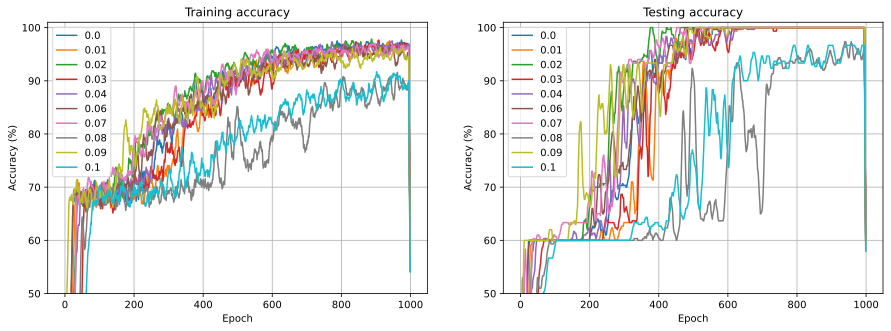

In [20]:
# plot results
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(accuracy_results_train)
ax[0].set_title('Training accuracy')
ax[1].plot(accuracy_results_test)
ax[1].set_title('Testing accuracy')

leglabels = [np.round(i,2) for i in l2Lambdas]

for i in range(2):
  ax[i].legend(leglabels)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50, 101])
  ax[i].grid()

plt.show()

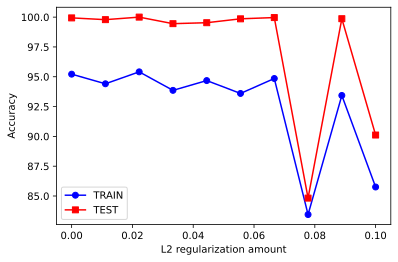

In [22]:

# show average accuracy by L2 rate

# average only some epochs
epoch_range = [500,950]


plt.plot(l2Lambdas,
         np.mean(accuracy_results_train[epoch_range[0]:epoch_range[1],:],axis=0),
         'bo-',label='TRAIN')

plt.plot(l2Lambdas,
         np.mean(accuracy_results_test[epoch_range[0]:epoch_range[1],:],axis=0),
         'rs-',label='TEST')

plt.xlabel('L2 regularization amount')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
     